# Classificeren van sterrenstelsels op basis van foto's

In dit project ga ik proberen sterrenstelsels te classificeren op basis van foto's. De basis hiervoor is de GALAXY10-decals dataset. Deze bestaat uit 17.736 foto's van sterrenstelsels, verdeeld over 10 klassen. De labeling is gedaan op basis van 'volunteer votes'.


<iframe src="https://astronn.readthedocs.io/en/latest/galaxy10.html" width="1920" height="1080"></iframe>

In [1]:
# laden van libraries

%load_ext autoreload
%autoreload 2

%pip install opencv-python 
%pip install git+https://github.com/henrysky/astroNN.git 

from astroNN.datasets.galaxy10 import galaxy10cls_lookup
from pathlib import Path
import os
import h5py
import numpy as np
import sys
import tensorflow as tf
import matplotlib.pyplot as plt

sys.path.insert(0, "..")
sys.path


# directories bepalen
datadir_processed = Path("../data/processed")
datadir_raw = Path("../data/raw")

# functies beschikbaar maken
from src.data import data_pre

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\hjtfs\AppData\Local\pypoetry\Cache\virtualenvs\hu-deeplearning-lSm0EZYV-py3.8\Scripts\python.exe -m pip install --upgrade pip' command.
  Running command git clone --filter=blob:none -q https://github.com/henrysky/astroNN.git 'C:\Users\hjtfs\AppData\Local\Temp\pip-req-build-1gwhx5mo'
You should consider upgrading via the 'C:\Users\hjtfs\AppData\Local\pypoetry\Cache\virtualenvs\hu-deeplearning-lSm0EZYV-py3.8\Scripts\python.exe -m pip install --upgrade pip' command.


  Cloning https://github.com/henrysky/astroNN.git to c:\users\hjtfs\appdata\local\temp\pip-req-build-1gwhx5mo
  Resolved https://github.com/henrysky/astroNN.git to commit 573ab50d4a2ab1ab89699de2245d35297ce69b2f
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'



### Downloaden van de galaxy10decals dataset

De dataset wordt gedownload van de astroNN website. Het is een set van 2.6 GB in h5 formaat.

In [2]:
data_pre.get_raw_data(datadir_raw) # takes a few minutes (2.6 GB)

2022-02-13 11:06:37.751 | INFO     | src.data.data_pre:get_raw_data:23 - found Galaxy10_decals.h5 in ..\data\raw, not downloading again


Ik kijk welke features in het bestand aanwezig zijn.

In [3]:
hf = h5py.File(datadir_raw /"Galaxy10_decals.h5", 'r')
key_list = list(hf.keys())
print ("keys in file: " + ', '.join(key_list))

keys in file: ans, dec, images, pxscale, ra, redshift


Ik ben alleen geïnteresseerd in de foto's en de labels. Uit de documentatie haal ik dat dit de images en ans keys zijn. Deze zet ik om in arrays voor verdere verwerking. Ik tel ook het aantal per label.

In [4]:
images = np.array(hf['images']) # omzetten naar array
labels = np.array(hf['ans'])

counts = np.unique(labels, return_counts=True) # unieke labels vaststellen en het aantal foto's daarbij

print("number per label:")
print (counts)

number per label:
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([1081, 1853, 2645, 2027,  334, 2043, 1829, 2628, 1423, 1873],
      dtype=int64))


De labels bestaan uit de integers 0 tm 9, maar ik wil graag de beschrijving van de labels zien. Deze haal ik op met behulp van de galaxy10 lookup functie.

In [5]:
# ophalen van de omschrijving van alle unieke labels
unique_labels = list(set(labels))

galaxy_types = []
for j in unique_labels:
    names = galaxy10cls_lookup(j)
    galaxy_types.append(names)

print(galaxy_types)

['Disturbed', 'Merging', 'Round Smooth', 'Smooth, Cigar shaped', 'Cigar Shaped Smooth', 'Barred Spiral', 'Unbarred Tight Spiral', 'Unbarred Loose Spiral', 'Edge-on without Bulge', 'Edge-on with Bulge']


## H5 formaat en het verder verwerken van de dataset

De dataset is in een format dat gebruikt kan worden voor analyse en het bouwen van modellen. In alle lessen is Raoul echter uitgegaan van foto's die in een mappenstructuur zijn opgedeeld. <br>
Om makkelijk code van Raoul te kunnen hergebruiken ga ik de dataset ook opsplitsen en opslaan in een mappenstructuur. En ik vind het ook gewoon leuk om al die kleine thumbnails te kunnen zien :) <br>
Ik gebruik de mogelijkheid ook om de foto's te downsizen naar 64x64 pixels in verband met de opslagcapaciteit van Guthub en de snelheid van de training van de modellen.

In [6]:
# voor iedere klasse een directory aanmaken als die nog niet bestaat
data_pre.sub_folders(datadir_processed, datadir_raw, galaxy_types) 

2022-02-13 11:07:13.609 | INFO     | src.data.data_pre:sub_folders:48 - Main folder ..\data\processed allready exists
2022-02-13 11:07:13.610 | INFO     | src.data.data_pre:sub_folders:56 - Subfolder ..\data\processed\Disturbed allready exists
2022-02-13 11:07:13.611 | INFO     | src.data.data_pre:sub_folders:56 - Subfolder ..\data\processed\Merging allready exists
2022-02-13 11:07:13.612 | INFO     | src.data.data_pre:sub_folders:56 - Subfolder ..\data\processed\Round Smooth allready exists
2022-02-13 11:07:13.612 | INFO     | src.data.data_pre:sub_folders:56 - Subfolder ..\data\processed\Smooth, Cigar shaped allready exists
2022-02-13 11:07:13.613 | INFO     | src.data.data_pre:sub_folders:56 - Subfolder ..\data\processed\Cigar Shaped Smooth allready exists
2022-02-13 11:07:13.613 | INFO     | src.data.data_pre:sub_folders:56 - Subfolder ..\data\processed\Barred Spiral allready exists
2022-02-13 11:07:13.614 | INFO     | src.data.data_pre:sub_folders:56 - Subfolder ..\data\processed\

In [7]:
# tellen van de aanwezige foto's in iedere subdirectory
printcount = 'y'
data_pre.count_images(datadir_processed, printcount, galaxy_types)

Disturbed 1081
Merging 1853
Round Smooth 2645
Smooth, Cigar shaped 2027
Cigar Shaped Smooth 334
Barred Spiral 2043
Unbarred Tight Spiral 1829
Unbarred Loose Spiral 2628
Edge-on without Bulge 1423
Edge-on with Bulge 1873
Total number of images: 17736


In [8]:
# opslaan van losse foto's in iedere subdirectory, als die nog niet aanwezig zijn
data_pre.process_data(datadir_processed, datadir_raw, galaxy_types, images, labels)

2022-02-13 11:07:14.031 | INFO     | src.data.data_pre:process_data:115 - Data allready exists


In [9]:
# berekenen van de grootte van de opgeslagen data
print(data_pre.get_size(datadir_processed), 'MB')

50.600152 MB


Found 17736 files belonging to 10 classes.


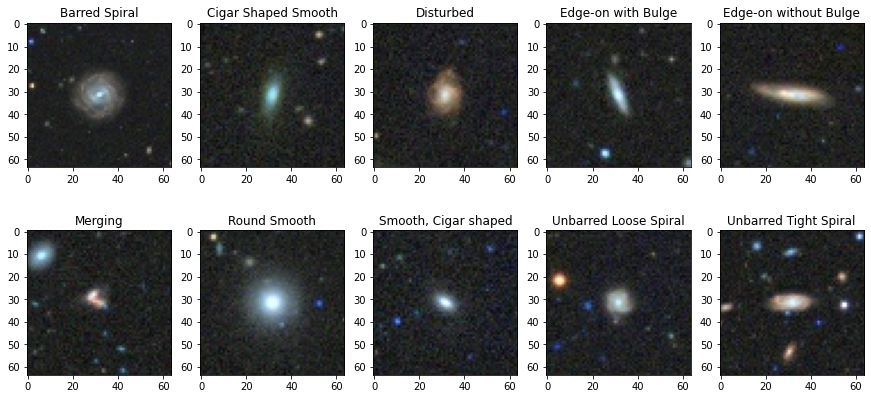

In [10]:
# Totaal dataset maken en van iedere klasse één foto tonen

whole = tf.keras.utils.image_dataset_from_directory(
    datadir_processed, labels='inferred', label_mode='int', image_size=(64,
    64))

class_names = whole.class_names
plt.figure(figsize=(15, 7))
for i in range(len(class_names)):
    filtered_whole = whole.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_whole.take(1):
        ax = plt.subplot(2, 5, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('on')

# Observaties en hypotheses

De volgende zaken vallen mij op:

- De klassen zijn door vrijwilligers ingedeeld, op basis van 'meeste stemmen gelden'
- De 'Cigar Shaped Smooth' klasse is erg klein vergeleken met de andere klassen. En er is een andere klasse die 'Smooth, Cigar shaped' heet. Dat klinkt erg vergelijkbaar.
- De voorbeeldfoto's zijn vaak niet erg scherp
- Op de voorbeeldfoto's staat het stelsel in het midden, maar er staan ook allerlei andere sterren(stelsels) omheen
- Het verschil tussen verschillende klassen is voor mij amper te zien

Ik ga op basis hiervan uit van de volgende hypotheses:

- In de klassenindeling zitten menselijke fouten, dit zal de nauwkeurigheid van een model lager maken
- De 'class imbalance', vooral van de 'Cigar Shaped Smooth' klasse, zal het voor model moeilijker maken
- De matige kwaliteit van de foto's zal het voor een model moeilijker maken om verschillen te zien
- De hoeveelheid 'noise' op de foto's zal kan een model in de weg zitten, en de nauwkeurigheid slechter maken
- De verschillen tussen de klassen lijken klein te zijn, ook dit maakt het voor een model moeilijker.

Kortom, ik denk dat het een zeer uitdagende dataset is.
